In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/competitions/probspace_pricing/notebooks

[Errno 2] No such file or directory: 'drive/MyDrive/competitions/probspace_pricing/notebooks'
/content/drive/MyDrive/competitions/probspace_pricing/notebooks


In [ ]:
import glob
from IPython.display import display
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
#import japanize_matplotlib
import seaborn as sns 

In [ ]:
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows", 500)

# データ読み込み

In [ ]:
train_df = pd.read_csv("../data/raw/train.csv")
test_df = pd.read_csv("../data/raw/test.csv")
review_df = pd.read_csv("../data/raw/review.csv")

In [ ]:
all_df = pd.concat([train_df, test_df]).reset_index()

In [ ]:
all_df

,index,ID,OwnerID,OwnerSince,TimeToReply,ReplyRate,AcceptanceRate,IdentityVerified,Verifications,ListingsCount,HasPicture,OwnerDetail,Description,PropertyType,RoomType,MaximumAccommodates,InstantBookable,BathroomsText,Beds,Amenities,Bedrooms,AreaCategory,Latitude,Longitude,Availability,Vacancy30,Vacancy60,Vacancy90,Vacancy365,UserRatingOverall,UserRatingInformation,UserRatingCleanliness,UserRatingCheckin,UserRatingCommunication,UserRatingLocation,UserRatingPrice,NumberOfReviews,NumberOfReviews1m,NumberOfReviews1y,FirstReview,LastReview,ReviewsPerMonth,Price
0,0,0,15560,2020-03-15,a few days or more,0%,NaN,f,"[""phone""]",0.0,t,NaN,DUEÑO DIRECTO ALQUILA HABITACIONES INDIVIDUALE...,Private room in residential home,Private room,4,t,2 shared baths,4.0,"[""Iron"", ""First aid kit"", ""Lock on bedroom doo...",4.0,Almagro,-34.62,-58.41,t,30,60,89,89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,898.0
1,1,1,18859,2021-02-05,NaN,NaN,NaN,t,"[""phone"", ""identity_manual""]",1.0,t,NaN,Departamento Ubicado en plena zona de Palermo ...,Entire rental unit,Entire home/apt,4,t,2.5 baths,4.0,"[""Iron"", ""Heating"", ""Kitchen"", ""Fire extinguis...",2.0,Palermo,-34.58,-58.42,t,30,60,90,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,609213.0
2,2,2,35677,2016-07-11,NaN,NaN,NaN,f,"[""email"", ""phone"", ""reviews"", ""jumio"", ""offlin...",1.0,t,NaN,The room is furnished and located on the Aalsm...,Private room in rental unit,Private room,1,f,1 bath,1.0,"[""TV"", ""Washer"", ""Hangers"", ""Lock on bedroom d...",1.0,Zuid,52.35,4.85,t,0,0,0,0,4.00,5.00,4.00,5.00,5.00,4.00,4.00,1,0,0,2016-08-23,2016-08-23,0.02,3631.0
3,3,3,6930,2012-12-05,a few days or more,0%,0%,f,"[""phone"", ""reviews""]",2.0,t,Me and my family love to travel so we bought v...,<b>The space</b><br />Newly constructed buildi...,Entire condominium (condo),Entire home/apt,4,f,1 bath,2.0,"[""Iron"", ""Heating"", ""Smoke alarm"", ""Dryer"", ""C...",1.0,Palermo,-34.58,-58.42,t,29,59,89,364,4.28,4.71,4.53,4.76,4.88,4.82,4.18,19,0,0,2014-07-22,2018-11-11,0.22,5697.0
4,4,4,11872,2016-02-26,within an hour,100%,100%,t,"[""email"", ""phone"", ""reviews"", ""jumio"", ""offlin...",11.0,t,Hola! Somos noelia y matias!!! Departamentos a...,Amazing Studio located in the BEST PLACE of P...,Entire rental unit,Entire home/apt,2,f,1 bath,1.0,"[""Bed linens"", ""Host greets you"", ""Dedicated w...",1.0,Palermo,-34.58,-58.44,t,30,60,90,365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,2548.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69756,30281,69756,18662,2016-07-29,NaN,NaN,NaN,t,"[""email"", ""phone"", ""facebook"", ""reviews"", ""sel...",1.0,t,"Hi!\r\n\r\nNice to meet you, we are Rink and I...",Small house in Amsterdam 'Noord' <br />The pla...,Entire residential home,Entire home/apt,2,t,1 bath,1.0,"[""Coffee maker"", ""Backyard"", ""Bed linens"", ""Wi...",1.0,Noord-West,52.42,4.89,t,0,0,0,0,4.86,4.91,4.68,4.91,4.82,4.41,4.59,22,0,0,2017-12-10,2018-07-22,0.48,NaN
69757,30282,69757,29836,2020-10-01,within an hour,100%,67%,t,"[""email"", ""phone"", ""jumio"", ""offline_governmen...",2.0,t,NaN,NaN,Private room in residential home,Private room,1,f,1 private bath,1.0,"[""Lock on bedroom door"", ""Wifi"", ""Hot water"", ...",NaN,NANNUP,-33.98,115.77,t,23,49,79,79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN
69758,30283,69758,30781,2016-08-05,NaN,NaN,100%,f,"[""email"", ""phone""]",1.0,t,Im Asal 29 years old. living/working in Amster...,Modern and light apartment 4 minutes walk from...,Entire rental unit,Entire home/apt,2,f,1 bath,1.0,"[""Coffee maker"", ""Long term stays allowed"", ""P...",1.0,Zuid,52.35,4.85,t,27,57,87,177,4.00,5.00,5.00,5.00,5.00,5.00,4.00,1,0,0,2019-04-28,2019-04-28,0.03,NaN
69759,30284,69759,16312,2015-09-16,within an hour,100%,NaN,f,"[""email"", ""phone"", ""reviews"", ""jumio""]",2.0,t,Hassle free on a holiday :-) \r\n\r\nWe made y...,Waking up i

# 前処理

## 日付処理


1.   数値に変換
2.   年、月を抽出



*   OwnerSince
*   FirstReview
* LastReview



数値に変換

In [ ]:
# 日付の文字列を数値に変換する関数
def transform_date(df, column):
    df[column] = df[column].str.replace("-", "").apply(float)
    return df

In [ ]:
for i in ["OwnerSince","FirstReview","LastReview"]:
    all_df = transform_date(all_df, i)

年、月を抽出

In [ ]:
# 月、年を抽出してDFに追加する関数
def extract_month_year(df, column):
    df["{}_year".format(column)] = df[column].apply(lambda x: int(str(x)[:4]) if not (x is np.nan) else np.nan)
    df["{}_month".format(column)] = df[column].apply(lambda x: int(str(x)[4:6]) if not (x is np.nan) else np.nan)
    return df

In [ ]:
# for i in ["OwnerSince","FirstReview","LastReview"]:
#     all_df = extract_month_year(all_df, i)

## 文字列→数値

*   ReplyRate
*   AcceptanceRate



In [ ]:
# %を数値に変換する
def transform_percent_to_number(df, column):
    df[column] = df[column].str.replace("%","").apply(float)
    return df

In [ ]:
for col in ["ReplyRate", "AcceptanceRate"]:
    all_df = transform_percent_to_number(all_df, col)

## フラグ作成


*   ReplyRate
*   AcceptanceRate



In [ ]:
# 100.0ならフラグを立てる関数
def create_flag(df, column):
    df["{}_100%".format(column)] = df[column].apply(lambda x: 1 if x==100.0 else 0)
    return df

In [ ]:
for col in ["ReplyRate", "AcceptanceRate"]:
    all_df = create_flag(all_df, col)

## Verifications

*   媒体別にダミー変数化
* 対応媒体数個数も特徴量にする



In [ ]:
# 使われている媒体を取り出し
virification_sets = set()
for i in range(len(all_df)):
    virification_sets = virification_sets.union(set(all_df["Verifications"][i].replace("[", "").replace('"', "").replace(']', "").replace(" ", "").split(",")))

In [ ]:
# 分割してリストにする
all_df["Verifications_list"] = all_df["Verifications"].apply(lambda x: x.replace("[", "").replace('"', "").replace(']', "").replace(" ", "").split(","))
# 集合の要素でループ
# リスト内にマッチすれば１とするダミー変数を追加
for verification in virification_sets:
    all_df["Veif_{}".format(verification)] = all_df["Verifications_list"].apply(lambda x: 1 if verification in x else 0)


In [ ]:
# リストは削除
all_df.drop(columns="Verifications_list", inplace=True)

## 外れ値の処理


*   Price
*   Bedrooms



## Latitude/Longitude


*   地域を表す変数（所在地や最寄駅）→クラスタリングで代用



In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# クラスタリング
kmeans = MiniBatchKMeans(n_clusters=10, random_state=123)
kmeans.fit(all_df[["Longitude","Latitude"]])

MiniBatchKMeans(n_clusters=10, random_state=123)

In [ ]:
# 特徴量：属するクラスタ
all_df["Cluster"] = kmeans.predict(all_df[["Longitude","Latitude"]])
# 特徴量：クラスタの中心までの距離
distance_array = kmeans.transform(all_df[["Longitude","Latitude"]])
for i in range(distance_array.shape[1]):
    all_df["Distance_{}".format(i)] = distance_array[: , i]

2    18431
0    10643
4     9621
1     8291
5     7810
3     5495
8     5439
9     2740
6      906
7      385
Name: Cluster, dtype: int64


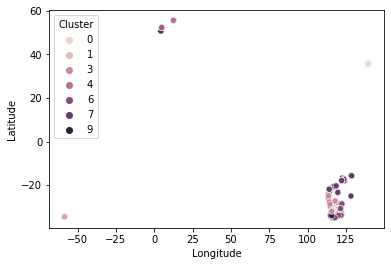

In [ ]:
print(all_df["Cluster"].value_counts())
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=all_df)

(33.0, 37.0)

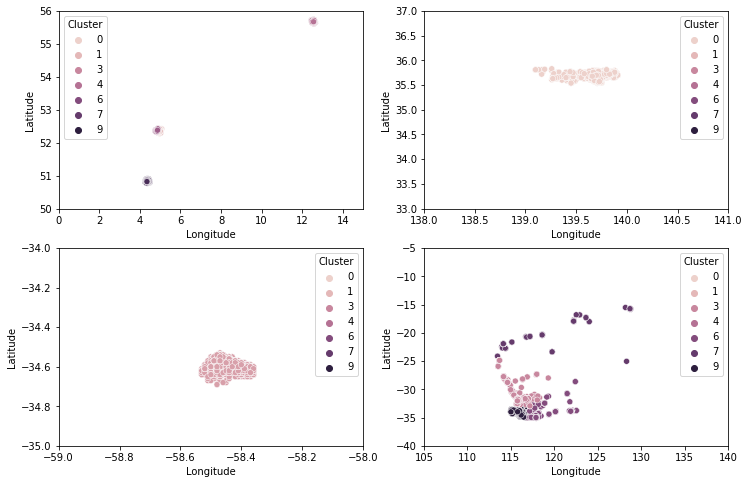

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# ブエノスアイレス
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=all_df, ax=axes[0][0],)
axes[0][0].set_xlim((0,15))
axes[0][0].set_ylim((50,56))

# ヨーロッパ
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=all_df, ax=axes[1][0])
axes[1][0].set_xlim((-59,-58))
axes[1][0].set_ylim((-35,-34))

# オーストラリア
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=all_df, ax=axes[1][1])
axes[1][1].set_xlim((105,140))
axes[1][1].set_ylim((-40,-5))

# 日本
sns.scatterplot(x='Longitude', y='Latitude', hue='Cluster', data=all_df, ax=axes[0][1])
axes[0][1].set_xlim((138,141))
axes[0][1].set_ylim((33,37))

## FirstReview/LastReview

* FirstReviewとLastReviewとの差
* OwnerSinceとの差

In [ ]:
# 年＊３６５＋月＊３０．５＋日で日に直して差を取る

# 自然言語処理



多言語Bert


　多言語モデル

## tf-idf


*   OwnerDtail
*   Description
* ReviewerName
* Review
* (PropertyType)
* (BathroomsText)
* (Amenities)





In [ ]:
from typing import List, Callable, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD, NMF

In [ ]:
# tf-idfと次元削減をする関数
def tfidf_encoding(df:pd.DataFrame, decompose_func:Callable, tokenizer=None, col=None):

    temp = df[col].str.lower()

    pipline = make_pipeline(
        TfidfVectorizer(tokenizer=tokenizer, min_df=2, ),
        decompose_func,
    )

    output_df = pipline.fit_transform(temp)
    output_df = pd.DataFrame(output_df)
    output_df.columns = [f"tfidf_{col}_{decompose_func.__class__.__name__}_{i}" for i in range(output_df.shape[1])]
    return output_df

In [ ]:
# nanを"NAN"に置換
for col in ["OwnerDetail","Description","PropertyType","BathroomsText","Amenities"]:
    # np.nanを"NAN"に置換
    all_df = all_df.replace({col: {np.nan: 'NAN'}})

for col in ["ReviewerName","Review"]:
    # np.nanを"NAN"に置換
    review_df = review_df.replace({col: {np.nan: 'NAN'}})

In [ ]:
# tf-idf + SVD
def tfidf_encoding_svd(df, col_list):
    for col in col_list:
        decompose_func = TruncatedSVD(n_components=20, random_state=42)
        tf_df = tfidf_encoding(df=df, decompose_func=decompose_func, col=col)
        # indexで結合
        df = pd.merge(df, tf_df, left_index=True, right_index=True)

    return df

In [ ]:
col_list1 = ["OwnerDetail","Description","PropertyType","Amenities"] # ,"BathroomsText" 20以下らしい
col_list2 = ["ReviewerName","Review"]
all_df = tfidf_encoding_svd(df=all_df, col_list=col_list1)
review_df = tfidf_encoding_svd(df=review_df, col_list=col_list2)

# reviewを結合

名前の処理をどうするか

In [ ]:
# ID毎に集計して平均を取る
review_group_df = review_df.groupby("ID").agg(np.mean)
# ID毎のカウントを取る
review_group_df["Review_count"] = review_df.groupby("ID").count()["ReviewerId"]
# IDでマージ
all_df = pd.merge(all_df, review_group_df, on="ID", how="left")

# ラベルエンコーディング

In [ ]:
# カテゴリ変数のカラム
obj_cats = all_df.dtypes[all_df.dtypes=="object"].index

# categoryにキャスト
for cat in obj_cats:
    all_df[cat] = all_df[cat].astype("category")

# 不要なカラム

In [ ]:
drop_cols = ["index","Verifications","Description","OwnerDetail","Description","PropertyType","BathroomsText","Amenities"]
all_df.drop(columns=drop_cols, inplace=True)

# モデル
lightgbm.cv (https://blog.amedama.jp/entry/lightgbm-cv-implementation)


In [ ]:
!pip install lightgbm==3.3.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.7 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit

In [ ]:
# データ準備
train = all_df[:len(train_df)]
test = all_df[len(train_df):].drop(columns=["Price"])
train_x = train.drop(columns=["Price"])
train_y = train["Price"]

In [ ]:
# 評価指標がMAEのため、あらかじめ目的変数に対数変換を施しておく
train_y = np.log1p(train_y)

# カテゴリ変数
categorical_features = list(train.dtypes[all_df.dtypes=="category"].index)

In [ ]:
%%time
params = {
    'boosting_type': 'gbdt', # fairとするとこれがないとうまくいかない
    'objective': 'fair',
    'metric': 'fair',
    "learning_rate": 0.1,
    # "deterministic": True,
    "verbosity": 1,
    # "feature_pre_filter": False,
    "lambda_l1": 2.471598727553709e-07,
    "lambda_l2": 7.067019500748873e-07,
    "num_leaves": 31, # 1 本の木の葉の最大数
    "feature_fraction": 0.8, # 決定木ごとに特徴量の列をサンプリングする割合
    "bagging_fraction": 1.0, # 決定木ごとに特徴量の行をサンプリングする割合
    "bagging_freq": 0, # baggingでデータサンプリングする頻度、０の場合はbaggingしない
    "min_child_samples": 20, # 1 枚の葉の最小データ数
    'early_stopping_rounds':100,
}

cv = lgb.cv(
    params = params,
    train_set = lgb.Dataset(train_x, label = train_y),
    num_boost_round = 1000,
    folds = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0),
    # nfold=5,
    metrics="mape",
    # feval=fairloss,
    categorical_feature=categorical_features,
    seed = 0,
    return_cvbooster = True
)

model = cv["cvbooster"]

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AreaCategory', 'Availability', 'HasPicture', 'IdentityVerified', 'InstantBookable', 'RoomType', 'TimeToReply']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32413
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32413
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32413
[LightGBM] [Info] Number of data points in the train set: 31580, number of used features: 183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.122326 seconds.
You can set

# 評価

In [ ]:
len(cv["mape-mean"])

1000

In [ ]:
cv["mape-mean"].pop()

0.035752990821908144

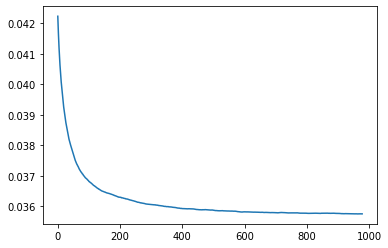

In [ ]:
plt.plot(cv["mape-mean"][20:])

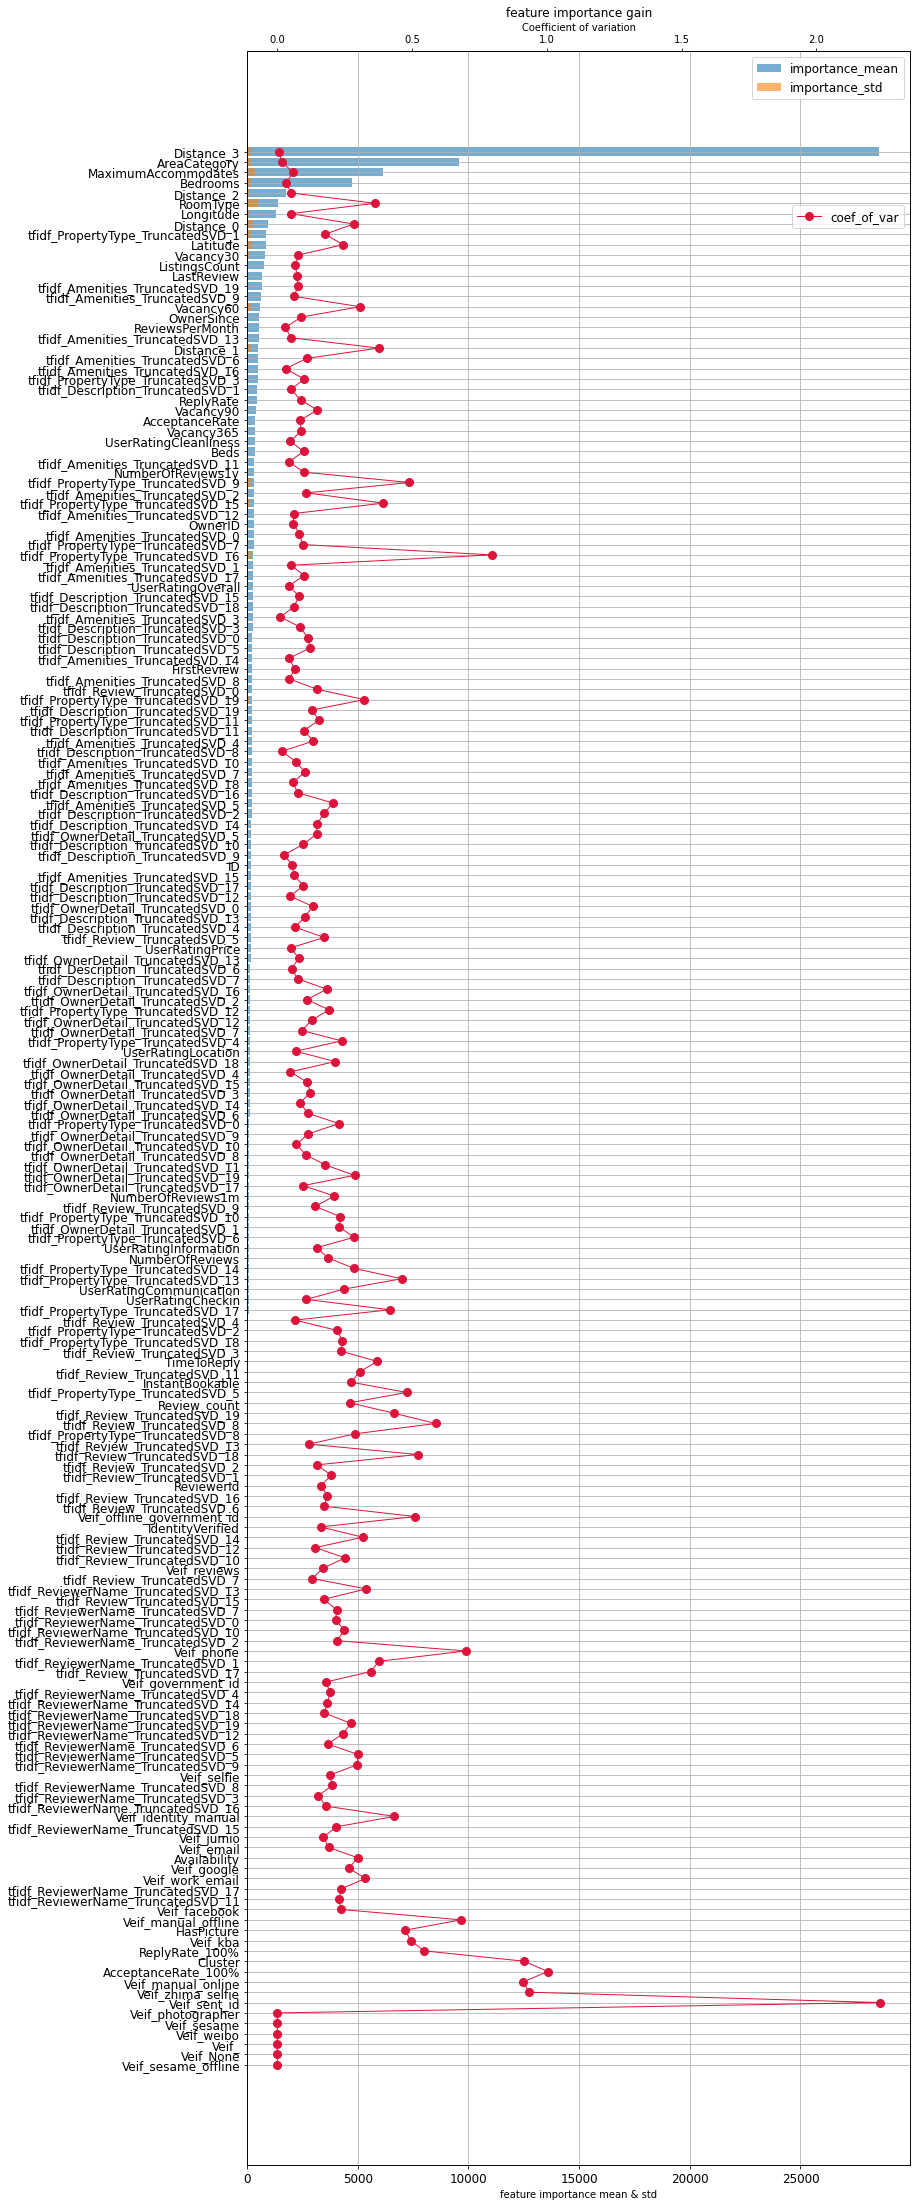

In [ ]:
def calc_feature_importance(cv_model, features):
    """feature importanceの計算,図の保存
    """
    val_gain = pd.DataFrame(data=model.feature_importance(importance_type='gain'),
                            columns=model.boosters[0].feature_name()).T

    # 各foldの平均を算出
    val_mean = val_gain.mean(axis=1)
    val_mean = val_mean.values
    importance_df_mean = pd.DataFrame(val_mean, index=features, columns=['importance']).sort_values('importance')

    # 各foldの標準偏差を算出
    val_std = val_gain.std(axis=1)
    val_std = val_std.values
    importance_df_std = pd.DataFrame(val_std, index=features, columns=['importance']).sort_values('importance')

    # マージ
    df = pd.merge(importance_df_mean, importance_df_std, left_index=True, right_index=True ,suffixes=['_mean', '_std'])

    # 変動係数を算出
    df['coef_of_var'] = df['importance_std'] / df['importance_mean']
    df['coef_of_var'] = df['coef_of_var'].fillna(0)
    df = df.sort_values('importance_mean', ascending=True)

    # 出力
    fig, ax1 = plt.subplots(figsize = (10, 30))
    plt.tick_params(labelsize=12) # 図のラベルのfontサイズ
    plt.tight_layout()
    # 棒グラフを出力
    ax1.set_title('feature importance gain')
    ax1.set_xlabel('feature importance mean & std')
    ax1.barh(df.index, df['importance_mean'], label='importance_mean',  align="center", alpha=0.6)
    ax1.barh(df.index, df['importance_std'], label='importance_std',  align="center", alpha=0.6)
    # 折れ線グラフを出力
    ax2 = ax1.twiny()
    ax2.plot(df['coef_of_var'], df.index, linewidth=1, color="crimson", marker="o", markersize=8, label='coef_of_var')
    ax2.set_xlabel('Coefficient of variation')
    # 凡例を表示（グラフ左上、ax2をax1のやや下に持っていく）
    ax1.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0.5, fontsize=12)
    ax2.legend(bbox_to_anchor=(1, 0.93), loc='upper right', borderaxespad=0.5, fontsize=12)
    # グリッド表示(ax1のみ)
    ax1.grid(True)
    ax2.grid(False)


calc_feature_importance(cv_model=model, features=model.boosters[0].feature_name())

# 提出

In [ ]:
# 交差検定の各モデルで予測した結果をアンサンブルしたものを、最終的な予測結果とする
submission = pd.DataFrame({
    "ID": test.index,
    "Price": np.expm1(np.array(model.predict(test)).mean(axis = 0))
})

In [ ]:
submission.to_csv("../data/submission/submission_baseline.csv", index = False, header = True)